In [1]:
from concurrent.futures import ThreadPoolExecutor
from os import cpu_count
from subprocess import check_call, check_output
from tempfile import TemporaryDirectory

import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from contextily import add_basemap
from planetary_computer import sign_inplace
from pystac_client import Client
from rasterio import transform
from scipy import ndimage
from skimage.exposure import rescale_intensity
from skimage.segmentation import slic

In [2]:
# Parameter
ROI = "central_kalimantan.geojson"
YEARS = [2020, 2022, 2024]
CATALOG = "https://planetarycomputer.microsoft.com/api/stac/v1/"
COLLECTION = "sentinel-1-rtc"
BANDS = ["vv", "vh"]
CPU_COUNT = cpu_count()
RESOLUTION = 30

(1559, 1525)

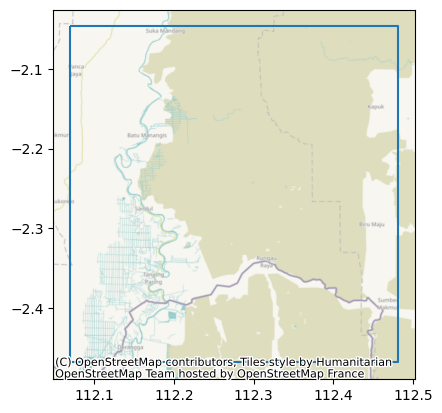

In [3]:
# Load region of interest and the bbox
roi_df = gpd.read_file(ROI)
ax = roi_df.boundary.plot()
add_basemap(ax=ax, crs="EPSG:4326")
bbox = tuple(roi_df.total_bounds)

# Define the optimal shape
width = int(abs(bbox[0] - bbox[2]) * 111_000 / RESOLUTION)
height = int(abs(bbox[1] - bbox[3]) * 111_000 / RESOLUTION)
shape = (height, width)
shape

In [4]:
# Function to load, clip, and reproject image
def warp_image(src: str) -> str:
    folder = TemporaryDirectory()
    output = f"{folder.name}/clipped.tif"

    print(f"Processing {src}")
    check_call(
        f"""rio warp \
            -r {RESOLUTION / 111_000} \
            --resampling lanczos \
            --co compress=zstd \
            --dst-crs EPSG:4326 \
            --dst-bounds {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]} \
            --dst-nodata 0 \
            "/vsicurl/{src}" \
            {output}
        """,
        shell=True,
    )

    with rio.open(output) as o:
        return (o.read(1, masked=True, out_shape=shape) * 1e4).astype("uint16")


# Function to create a median composite
def median_image(images):
    stack = np.ma.stack(images, dtype="uint16")
    median = np.ma.median(stack, axis=0, overwrite_input=True).astype("uint16")
    np.ma.set_fill_value(median, 0)
    return median


# Function to filter and create median composite of s1-rtc
def s1_median(year: int):
    # STAC client to search for sentinel-1-rtc data in microsoft planetary computer catalog
    client = Client.open(CATALOG, modifier=sign_inplace)

    # Search for items using our filter
    items = client.search(
        collections=[COLLECTION], datetime=(f"{year}-05", f"{year}-08"), bbox=bbox
    ).items()

    # Load all images with multithreading
    with ThreadPoolExecutor(CPU_COUNT) as executor:
        vv_jobs = []
        vh_jobs = []

        # Read inside each item
        for item in items:
            # Get the assets (link to bands)
            assets = item.assets

            # Read per bands
            for band in BANDS:
                path = assets[band].href
                if band == "vv":
                    vv_jobs.append(executor.submit(warp_image, path))
                else:
                    vh_jobs.append(executor.submit(warp_image, path))

        vv_images = []
        vh_images = []

        for job in vv_jobs:
            try:
                vv_images.append(job.result())
            except Exception as e:
                print(f"Error: {e.args}")

        for job in vh_jobs:
            try:
                vh_images.append(job.result())
            except Exception as e:
                print(f"Error: {e.args}")

    print("Median compositing VV")
    vv_median = median_image(vv_images)

    print("Median compositing VH")
    vh_median = median_image(vh_images)

    return vv_median, vh_median

In [5]:
# Generate median s1 for all the years
images_s1 = [dict(year=year, image=s1_median(year)) for year in YEARS]

Processing https://sentinel1euwestrtc.blob.core.windows.net/sentinel1-grd-rtc/GRD/2020/8/27/IW/DV/S1A_IW_GRDH_1SDV_20200827T221610_20200827T221635_034098_03F591_9BA2/measurement/iw-vv.rtc.tiff?st=2025-11-27T08%3A48%3A30Z&se=2025-11-28T09%3A33%3A30Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-11-28T08%3A48%3A18Z&ske=2025-12-05T08%3A48%3A18Z&sks=b&skv=2025-07-05&sig=qiMFr9XfNqaCOmgd7KmME2f/HqdTxv5P1dZ4vz6t/W4%3D
Processing https://sentinel1euwestrtc.blob.core.windows.net/sentinel1-grd-rtc/GRD/2020/8/27/IW/DV/S1A_IW_GRDH_1SDV_20200827T221610_20200827T221635_034098_03F591_9BA2/measurement/iw-vh.rtc.tiff?st=2025-11-27T08%3A48%3A30Z&se=2025-11-28T09%3A33%3A30Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-11-28T08%3A48%3A18Z&ske=2025-12-05T08%3A48%3A18Z&sks=b&skv=2025-07-05&sig=qiMFr9XfNqaCOmgd7KmME2f/HqdTxv5P1dZ4vz6t/W4%3D
Processing https://s

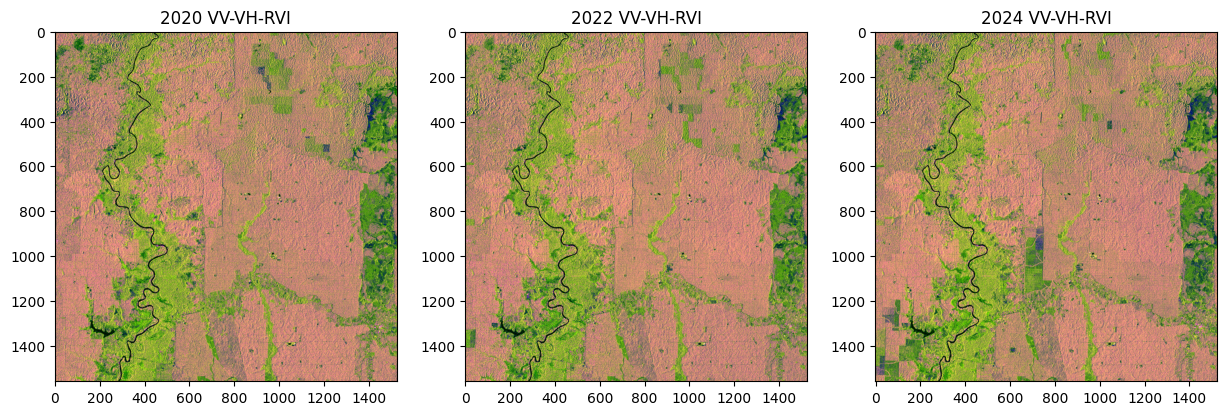

In [6]:
# Plot it per years
plt.figure(figsize=(15, 5))

for index in range(len(images_s1)):
    dict_image = images_s1[index]
    year = dict_image["year"]
    vv, vh = dict_image["image"]

    # Generate RVI
    rvi = ((vv / 1e4 - vh / 1e4) / (vv / 1e4 + vh / 1e4) * 1e4).astype("int16")

    # Add it to dict too..
    images_s1[index]["rvi"] = rvi

    # Rescale data for visualiztion
    composite = np.dstack(
        [
            rescale_intensity(vv, in_range=(1000, 4000), out_range=(0, 1)),
            rescale_intensity(vh, in_range=(0, 1000), out_range=(0, 1)),
            rescale_intensity(rvi, in_range=(5000, 10000), out_range=(0, 1)),
        ]
    )

    plt.subplot(1, 3, index + 1)
    plt.title(f"{year} VV-VH-RVI")
    plt.imshow(composite)

    # Add the composite to the dict for segmentation
    images_s1[index]["composite"] = composite

Generate segments 2020
Apply segmentation to image 2020
Create oil palm cover 2020
Saving oil palm raster 2020
Create polygon oil palm 2020
Generate segments 2022
Apply segmentation to image 2022
Create oil palm cover 2022
Saving oil palm raster 2022
Create polygon oil palm 2022
Generate segments 2024
Apply segmentation to image 2024
Create oil palm cover 2024
Saving oil palm raster 2024
Create polygon oil palm 2024


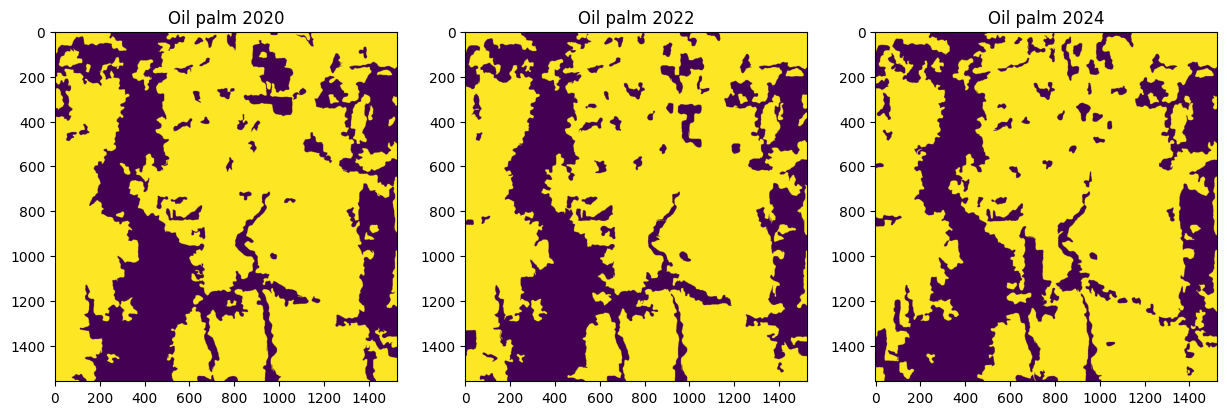

In [7]:
# Plot the oil palm cover too
plt.figure(figsize=(15, 5))


# Function to create oilpalm cover
def oil_palm(index: int):
    dict_images = images_s1[index]
    year = dict_images["year"]

    vv, vh = dict_images["image"]
    rvi = dict_images["rvi"]
    composite = dict_images["composite"]

    # Create segmentation
    print(f"Generate segments {year}")
    segments = slic(composite, n_segments=2000, sigma=5, compactness=5)

    # Create mean segmentation from the images
    unique = np.unique(segments)
    mean_vv = ndimage.mean(vv, labels=segments, index=unique)
    mean_vh = ndimage.mean(vh, labels=segments, index=unique)
    mean_rvi = ndimage.mean(rvi, labels=segments, index=unique)

    # map segment IDs to consecutive indices
    # (e.g., if unique = [1, 3, 7], mapping = {1:0, 3:1, 7:2})
    id_to_idx = np.zeros(segments.max() + 1, dtype=int)
    id_to_idx[unique] = np.arange(len(unique))

    # directly assign means using mapping
    print(f"Apply segmentation to image {year}")
    segments_vv = mean_vv[id_to_idx[segments]]
    segments_vh = mean_vh[id_to_idx[segments]]
    segments_rvi = mean_rvi[id_to_idx[segments]]

    # Create oil palm cover
    print(f"Create oil palm cover {year}")
    oil_palm = (segments_rvi > 6750) * (segments_vh < 750)
    images_s1[index]["oil_palm"] = oil_palm
    images_s1[index]["oil_palm_area"] = round(np.sum(oil_palm * 900 / 10_000))
    plt.subplot(1, 3, index + 1)
    plt.title(f"Oil palm {year}")
    plt.imshow(oil_palm)

    # Save as raster tiff
    print(f"Saving oil palm raster {year}")
    out_oil_palm = f"oil_palm_{year}.tif"
    with rio.open(
        out_oil_palm,
        "w",
        "COG",
        count=1,
        height=height,
        width=width,
        compress="zstd",
        nodata=0,
        dtype="uint8",
        crs="EPSG:4326",
        transform=transform.from_bounds(*bbox, height=height, width=width),
    ) as output:
        output.write(oil_palm, 1)

    # Create oil palm polygon
    print(f"Create polygon oil palm {year}")
    out_polygon = f"oil_palm_{year}.geojson"
    check_output(f"rio shapes --collection -o {out_polygon} {out_oil_palm}", shell=True)


# Run it per years
for index in range(len(images_s1)):
    oil_palm(index)

Save oil palm change 2020-2024
Create polygon oil palm change 2020-2024


b''

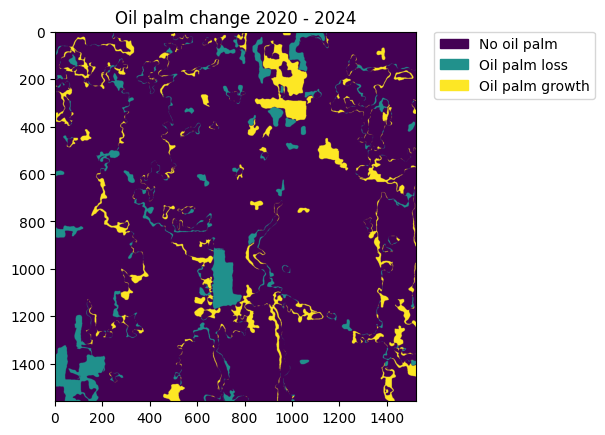

In [8]:
# Oil palm cover changes
oil_palm_2020, oil_palm_2022, oil_palm_2024 = [
    dict_image["oil_palm"] for dict_image in images_s1
]
oil_palm_changes = np.zeros(shape, dtype="uint8")
oil_palm_changes[~oil_palm_2020 & ~oil_palm_2024] = 0
oil_palm_changes[oil_palm_2020 & ~oil_palm_2024] = 1
oil_palm_changes[~oil_palm_2020 & oil_palm_2024] = 2

plt.title("Oil palm change 2020 - 2024")
im = plt.imshow(oil_palm_changes)

# get the colors of the values, according to the
# colormap used by imshow
values = [0, 1, 2]
labels = ["No oil palm", "Oil palm loss", "Oil palm growth"]
colors = [im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

# Save oil palm change raster
print("Save oil palm change 2020-2024")
out_oil_palm_change = "oil_palm_change_2020-2024.tif"
with rio.open(
    out_oil_palm_change,
    "w",
    "COG",
    count=1,
    height=height,
    width=width,
    compress="zstd",
    nodata=0,
    dtype="uint8",
    crs="EPSG:4326",
    transform=transform.from_bounds(*bbox, height=height, width=width),
) as output:
    output.write(oil_palm_changes, 1)

# Create oil palm polygon
print("Create polygon oil palm change 2020-2024")
out_polygon_oil_palm_change = "oil_palm_change_2020-2024.geojson"
check_output(
    f"rio shapes --collection -o {out_polygon_oil_palm_change} {out_oil_palm_change}",
    shell=True,
)

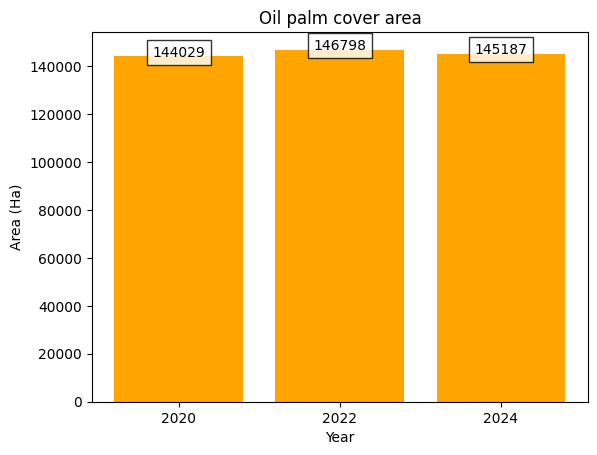

In [9]:
# oil palm cover change area size
plt.title("Oil palm cover area")
plt.bar(
    [f"{year}" for year in YEARS],
    [dict_image["oil_palm_area"] for dict_image in images_s1],
    color="orange"
)
plt.ylabel("Area (Ha)")
plt.xlabel("Year")

# Function to add labels inside a box
def add_labels(x, y):
    for i in range(len(x)):
        plt.text(
            i, y[i], y[i], ha="center", bbox=dict(facecolor="white", alpha=0.8)
        )  # Adding a red box around text

# Adding value labels
add_labels(
    [f"{year}" for year in YEARS],
    [dict_image["oil_palm_area"] for dict_image in images_s1],
)